In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-dataset/Covid Data.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

The dataset column description has been provided and i copied it for convenience purposes and removed some spelling errors

Source: https://www.kaggle.com/datasets/meirnizri/covid19-dataset/data

sex: 1 for female and 2 for male.
age: of the patient.
classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different
degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.

patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.

pneumonia: whether the patient already have air sacs inflammation or not.

pregnancy: whether the patient is pregnant or not.

diabetes: whether the patient has diabetes or not.

copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.

asthma: whether the patient has asthma or not.

inmsupr: whether the patient is immunosuppressed or not.

hypertension: whether the patient has hypertension or not.

cardiovascular: whether the patient has heart or blood vessels related disease.

renal chronic: whether the patient has chronic renal disease or not.

other disease: whether the patient has other disease or not.

obesity: whether the patient is obese or not.

tobacco: whether the patient is a tobacco user.

usmr: Indicates whether the patient treated medical units of the first, second or third level.

medical unit: type of institution of the National Health System that provided the care.

intubed: whether the patient was connected to the ventilator.

icu: Indicates whether the patient had been admitted to an Intensive Care Unit.

date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.

# Data Inspection and Cleaning

Import the data from the local repository and inspect its structure

In [3]:
covid_data = pd.read_csv("/kaggle/input/covid19-dataset/Covid Data.csv")

# Inspect the first elements
print(covid_data.head())

# List the column names
print(covid_data.columns)

# Get some basic information on the data
covid_data.info()

   USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE   DATE_DIED  INTUBED  PNEUMONIA  \
0      2             1    1             1  03/05/2020       97          1   
1      2             1    2             1  03/06/2020       97          1   
2      2             1    2             2  09/06/2020        1          2   
3      2             1    1             1  12/06/2020       97          2   
4      2             1    2             1  21/06/2020       97          2   

   AGE  PREGNANT  DIABETES  ...  ASTHMA  INMSUPR  HIPERTENSION  OTHER_DISEASE  \
0   65         2         2  ...       2        2             1              2   
1   72        97         2  ...       2        2             1              2   
2   55        97         1  ...       2        2             2              2   
3   53         2         2  ...       2        2             2              2   
4   68        97         1  ...       2        2             1              2   

   CARDIOVASCULAR  OBESITY  RENAL_CHRONIC  TOBACCO

There seem to be some spelling errors in the name of the columns. I changed those in order to provide more consistency with the list of the column names provided by the author

In [4]:
covid_data = covid_data.rename(columns = {"USMER" : "USMR","HIPERTENSION": "HYPERTENSION" })

covid_data.columns

Index(['USMR', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HYPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

Next steps

1) Missing values are coded as numeric, i change those to NaN
2) check for missing values in main outcome variable date_died
3) change date of death to binary format (1: has died, 2: alive)
4) change classification_final to binary (1: has covid, 2: does not have covid)

In [5]:
# 1. replace missing values
covid_data = covid_data.replace(97, np.NaN)
covid_data = covid_data.replace(98, np.NaN)
covid_data = covid_data.replace(99, np.NaN)

# 2. check for missing values in date_died

print("Sum of NA values in the datei_died column is: ", covid_data['DATE_DIED'].isnull().sum())

# 3. change data of death to binary

covid_data.loc[covid_data.DATE_DIED != "9999-99-99" ,'DATE_DIED'] = 1
covid_data.loc[covid_data.DATE_DIED == "9999-99-99" ,'DATE_DIED'] = 2

# 4. change classfication_final to binary

covid_data.loc[covid_data.CLASIFFICATION_FINAL <= 3, 'CLASIFFICATION_FINAL'] = 1
covid_data.loc[covid_data.CLASIFFICATION_FINAL > 3, 'CLASIFFICATION_FINAL'] = 2



Sum of NA values in the datei_died column is:  0


In [6]:
print(covid_data.head())

print(covid_data.info())

   USMR  MEDICAL_UNIT  SEX  PATIENT_TYPE DATE_DIED  INTUBED  PNEUMONIA   AGE  \
0     2             1    1             1         1      NaN        1.0  65.0   
1     2             1    2             1         1      NaN        1.0  72.0   
2     2             1    2             2         1      1.0        2.0  55.0   
3     2             1    1             1         1      NaN        2.0  53.0   
4     2             1    2             1         1      NaN        2.0  68.0   

   PREGNANT  DIABETES  ...  ASTHMA  INMSUPR  HYPERTENSION  OTHER_DISEASE  \
0       2.0       2.0  ...     2.0      2.0           1.0            2.0   
1       NaN       2.0  ...     2.0      2.0           1.0            2.0   
2       NaN       1.0  ...     2.0      2.0           2.0            2.0   
3       2.0       2.0  ...     2.0      2.0           2.0            2.0   
4       NaN       1.0  ...     2.0      2.0           1.0            2.0   

   CARDIOVASCULAR  OBESITY  RENAL_CHRONIC  TOBACCO  CLASIFFICA

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Some column types were changed to object in the process. I chose to convert them back to int.


In [7]:
# convert the date_died column to float
covid_data.DATE_DIED = covid_data.DATE_DIED.apply(lambda x: float(x))
# change name of the date_died column to represent the meaning in a better way
covid_data = covid_data.rename(columns = {"DATE_DIED": "DECEASED"})
# check the resulting data
print(covid_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   USMR                  1048575 non-null  int64  
 1   MEDICAL_UNIT          1048575 non-null  int64  
 2   SEX                   1048575 non-null  int64  
 3   PATIENT_TYPE          1048575 non-null  int64  
 4   DECEASED              1048575 non-null  float64
 5   INTUBED               192706 non-null   float64
 6   PNEUMONIA             1032572 non-null  float64
 7   AGE                   1048230 non-null  float64
 8   PREGNANT              521310 non-null   float64
 9   DIABETES              1045237 non-null  float64
 10  COPD                  1045572 non-null  float64
 11  ASTHMA                1045596 non-null  float64
 12  INMSUPR               1045171 non-null  float64
 13  HYPERTENSION          1045471 non-null  float64
 14  OTHER_DISEASE         1043530 non-

# Data visualisation 

First visualisation of the data for more insight

1) How many people were treated as inpatient vs. outpatient
2) How many people had covid
3) Amount of patients deceased
4) How many patients visited the ICU
5) Number of NAs per column? (Especially ICU and Intubed columns)

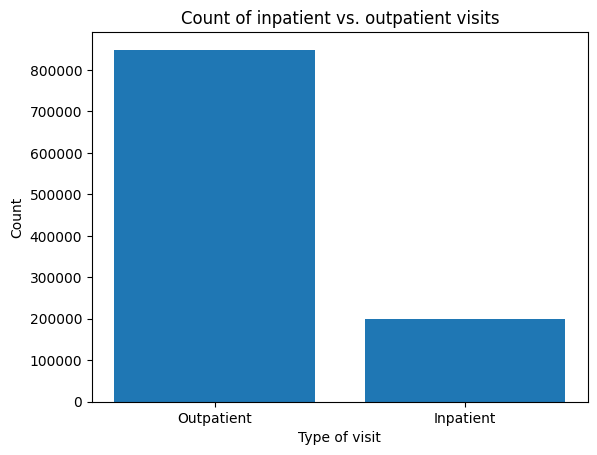

In [8]:
patient_type_count = list()
patient_type_count.append(covid_data[covid_data.PATIENT_TYPE == 1].PATIENT_TYPE.count())
patient_type_count.append(covid_data[covid_data.PATIENT_TYPE == 2].PATIENT_TYPE.count())
patient_type = ["Outpatient", "Inpatient"]

plt.bar(patient_type, height = patient_type_count)
plt.title("Count of inpatient vs. outpatient visits")
plt.xlabel("Type of visit")
plt.ylabel("Count")
plt.show()

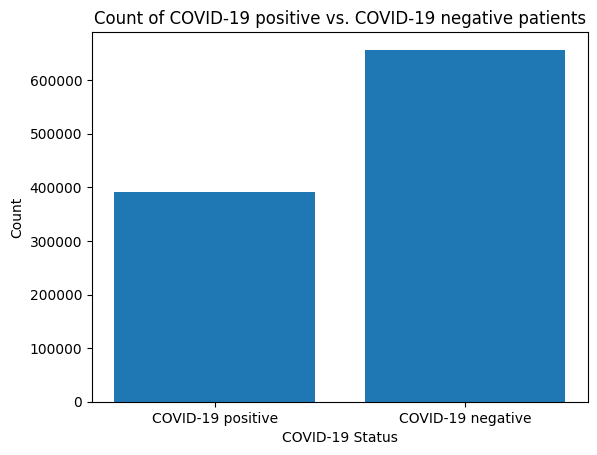

In [9]:
covid_count = list()
covid_count.append(covid_data[covid_data.CLASIFFICATION_FINAL == 1].CLASIFFICATION_FINAL.count())
covid_count.append(covid_data[covid_data.CLASIFFICATION_FINAL == 2].CLASIFFICATION_FINAL.count())
covid_type = ["COVID-19 positive", "COVID-19 negative"]

plt.bar(covid_type, height = covid_count)
plt.title("Count of COVID-19 positive vs. COVID-19 negative patients")
plt.xlabel("COVID-19 Status")
plt.ylabel("Count")
plt.show()

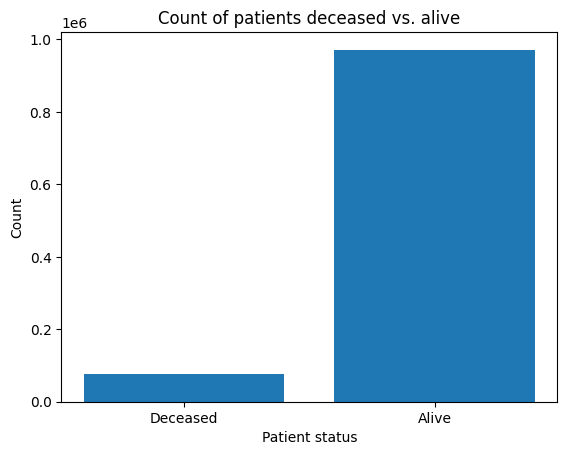

The number of patients which died in this data is:  76942
The number of patients which are alive:  971633


In [10]:
# Patients deceased
deceased_count = list()
deceased_count.append(covid_data[covid_data.DECEASED == 1].DECEASED.count())
deceased_count.append(covid_data[covid_data.DECEASED == 2].DECEASED.count())
deceased_type = ["Deceased", "Alive"]

plt.bar(deceased_type, height = deceased_count)
plt.title("Count of patients deceased vs. alive")
plt.xlabel("Patient status")
plt.ylabel("Count")
plt.show()

print("The number of patients which died in this data is: ", deceased_count[0])
print("The number of patients which are alive: ", deceased_count[1])

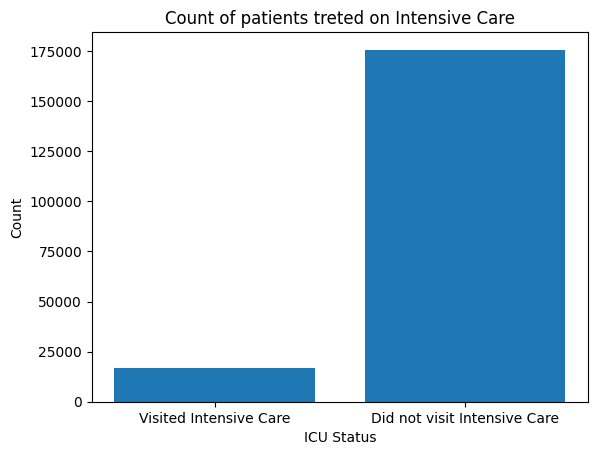

The number of patients which stayed in the ICU in this data is:  16858
The number of patients which did not stay in ICU:  175685


In [11]:
# Amount of patients that visited the ICU
icu_count = list()
icu_count.append(covid_data[covid_data.ICU == 1].ICU.count())
icu_count.append(covid_data[covid_data.ICU == 2].ICU.count())
icu_type = ["Visited Intensive Care", "Did not visit Intensive Care"]

plt.bar(icu_type, height = icu_count)
plt.title("Count of patients treted on Intensive Care")
plt.xlabel("ICU Status")
plt.ylabel("Count")
plt.show()

print("The number of patients which stayed in the ICU in this data is: ", icu_count[0])
print("The number of patients which did not stay in ICU: ", icu_count[1])

In [12]:
# Number of NAs per column

for column in covid_data.columns:
    print("Count of NA Values in column", column, "is: ", covid_data[column].isna().sum())

Count of NA Values in column USMR is:  0
Count of NA Values in column MEDICAL_UNIT is:  0
Count of NA Values in column SEX is:  0
Count of NA Values in column PATIENT_TYPE is:  0
Count of NA Values in column DECEASED is:  0
Count of NA Values in column INTUBED is:  855869
Count of NA Values in column PNEUMONIA is:  16003
Count of NA Values in column AGE is:  345
Count of NA Values in column PREGNANT is:  527265
Count of NA Values in column DIABETES is:  3338
Count of NA Values in column COPD is:  3003
Count of NA Values in column ASTHMA is:  2979
Count of NA Values in column INMSUPR is:  3404
Count of NA Values in column HYPERTENSION is:  3104
Count of NA Values in column OTHER_DISEASE is:  5045
Count of NA Values in column CARDIOVASCULAR is:  3076
Count of NA Values in column OBESITY is:  3032
Count of NA Values in column RENAL_CHRONIC is:  3006
Count of NA Values in column TOBACCO is:  3220
Count of NA Values in column CLASIFFICATION_FINAL is:  0
Count of NA Values in column ICU is: 

In [13]:
# Since there are many missing values in the pregnant column we inspect that further

print("Pregnant females overview: ", covid_data[covid_data.SEX == 1].PREGNANT.value_counts(dropna=False))

print("Pregnant males overview: ", covid_data[covid_data.SEX == 2].PREGNANT.value_counts(dropna=False))

Pregnant females overview:  PREGNANT
2.0    513179
1.0      8131
NaN      3754
Name: count, dtype: int64
Pregnant males overview:  PREGNANT
NaN    523511
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


It seems that all males were assigned NaN values for pregnangcy while they couldn't have been pregnant. Therefore i replaced all male NaNs in pregnancy with 2

In [14]:
# change males with missing values for pregnancy to 2: not pregnant
covid_data.loc[(covid_data.SEX == 2) , "PREGNANT"] = 2 

After cleaning all categorical values should be categorical and otherwise NaN, therefore all categorical values should have a maximum of three unique values (1,2,NaN) lets control that.

In [15]:
for column in covid_data.columns:

    print(column, len(covid_data[column].unique()))

USMR 2
MEDICAL_UNIT 13
SEX 2
PATIENT_TYPE 2
DECEASED 2
INTUBED 3
PNEUMONIA 3
AGE 119
PREGNANT 3
DIABETES 3
COPD 3
ASTHMA 3
INMSUPR 3
HYPERTENSION 3
OTHER_DISEASE 3
CARDIOVASCULAR 3
OBESITY 3
RENAL_CHRONIC 3
TOBACCO 3
CLASIFFICATION_FINAL 2
ICU 3


Medical unit has many unique values, lets inspect them

In [16]:
covid_data.MEDICAL_UNIT.value_counts()

MEDICAL_UNIT
12    602995
4     314405
6      40584
9      38116
3      19175
8      10399
10      7873
5       7244
11      5577
13       996
7        891
2        169
1        151
Name: count, dtype: int64

The column medical unit is of type category. For further analysis it would be beneficial to convert it into dichotomous variables.

In [17]:
covid_data = pd.get_dummies(covid_data, columns = ["MEDICAL_UNIT"])

# Prepare the data for analysis

1. Split labels and data
2. create train and test dataset
3. Inspect the data

In [18]:
# Split labels and data
X = covid_data.drop(columns = "DECEASED")
y = covid_data.DECEASED

In [19]:
# create train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=4790)

In [20]:
# Inspect the data
print("Shape of X_train is:", X_train.shape)
print( "Shape of X_test is:", X_test.shape)
print( "Shape of y_train is:", y_train.shape)
print( "Shape of y_test is:", y_test.shape)

Shape of X_train is: (702545, 32)
Shape of X_test is: (346030, 32)
Shape of y_train is: (702545,)
Shape of y_test is: (346030,)


# Select significant variables ??? necessary?

# Build first model

I chose the histgradient boosting classifier because it allows for data with NaN

In [21]:
clf = HistGradientBoostingClassifier(max_iter = 100, random_state = 4790)
clf.fit(X_train, y_train)


HistGradientBoostingClassifier(random_state=4790)

In [22]:
# predict on the test data
clf.score(X_test,y_test)

0.9511025055631015

<Axes: >

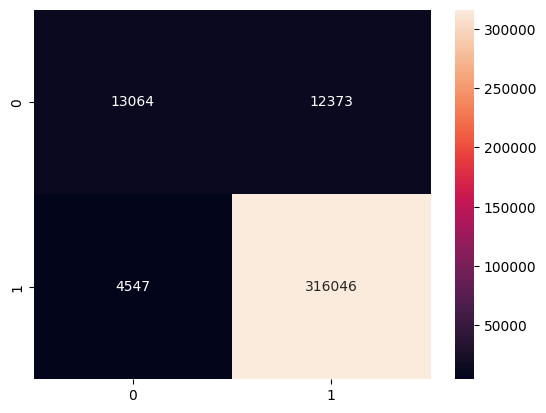

In [23]:
# Confusion matrix
y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix,annot=True, fmt= ".0f")